# Push-T Imitation Learning With Transformer

## Load Dataset

In [1]:
import os # to deal with files
import gdown # to download from google drive
import zipfile # to unzip
import zarr # to load the dataset
# download demonstration data from Google Drive
dataset_path = "pusht_cchi_v7_replay.zarr.zip"
extracted_dataset_path = "pusht_cchi_v7_replay.zarr"  # Path to extracted dataset

if not os.path.isfile(dataset_path):
    id = "1KY1InLurpMvJDRb14L9NlXT_fEsCvVUq&confirm=t"
    gdown.download(id=id, output=dataset_path, quiet=False)

# Extract the dataset if it hasn't been extracted yet
if not os.path.isdir(extracted_dataset_path):
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_dataset_path)

In [2]:
import numpy as np
import torch

def create_sample_indices(
        episode_ends:np.ndarray, sequence_length:int,
        pad_before: int=0, pad_after: int=0):
    indices = list()
    for i in range(len(episode_ends)):
        start_idx = 0
        if i > 0:
            start_idx = episode_ends[i-1]
        end_idx = episode_ends[i]
        episode_length = end_idx - start_idx

        min_start = -pad_before
        max_start = episode_length - sequence_length + pad_after

        # range stops one idx before end
        for idx in range(min_start, max_start+1):
            buffer_start_idx = max(idx, 0) + start_idx
            buffer_end_idx = min(idx+sequence_length, episode_length) + start_idx
            start_offset = buffer_start_idx - (idx+start_idx)
            end_offset = (idx+sequence_length+start_idx) - buffer_end_idx
            sample_start_idx = 0 + start_offset
            sample_end_idx = sequence_length - end_offset
            indices.append([
                buffer_start_idx, buffer_end_idx,
                sample_start_idx, sample_end_idx])
    indices = np.array(indices)
    return indices


def sample_sequence(train_data, sequence_length,
                    buffer_start_idx, buffer_end_idx,
                    sample_start_idx, sample_end_idx):
    result = dict()
    for key, input_arr in train_data.items():
        sample = input_arr[buffer_start_idx:buffer_end_idx]
        data = sample
        if (sample_start_idx > 0) or (sample_end_idx < sequence_length):
            data = np.zeros(
                shape=(sequence_length,) + input_arr.shape[1:],
                dtype=input_arr.dtype)
            if sample_start_idx > 0:
                data[:sample_start_idx] = sample[0]
            if sample_end_idx < sequence_length:
                data[sample_end_idx:] = sample[-1]
            data[sample_start_idx:sample_end_idx] = sample
        result[key] = data
    return result

# normalize data
def get_data_stats(data):
    data = data.reshape(-1,data.shape[-1])
    stats = {
        'min': np.min(data, axis=0),
        'max': np.max(data, axis=0)
    }
    return stats

def normalize_data(data, stats):
    # nomalize to [0,1]
    ndata = (data - stats['min']) / (stats['max'] - stats['min'])
    # normalize to [-1, 1]
    ndata = ndata * 2 - 1
    return ndata

def unnormalize_data(ndata, stats):
    ndata = (ndata + 1) / 2
    data = ndata * (stats['max'] - stats['min']) + stats['min']
    return data

# Returns
# All possible segments with length pred_horizon
# Pads the beginning and the end of each episode with repetition
# key image: shape (obs_hoirzon, 3, 96, 96)
# key agent_pos: shape (obs_hoirzon, 2)
# key action: shape (pred_horizon, 2)
class PushTImageDataset(torch.utils.data.Dataset):
    def __init__(self,
                 dataset_path: str,
                 pred_horizon: int,
                 obs_horizon: int,
                 action_horizon: int):

        # read from zarr dataset
        dataset_root = zarr.open(dataset_path, 'r')

        # float32, [0,1], (N,96,96,3)
        train_image_data = dataset_root['data']['img'][:]
        train_image_data = np.moveaxis(train_image_data, -1,1)
        # (N,3,96,96)

        # (N, D)
        train_data = {
            # first two dims of state vector are agent (i.e. gripper) locations
            'agent_pos': dataset_root['data']['state'][:,:2],
            'action': dataset_root['data']['action'][:]
        }
        episode_ends = dataset_root['meta']['episode_ends'][:]

        # compute start and end of each state-action sequence
        # also handles padding
        indices = create_sample_indices(
            episode_ends=episode_ends,
            sequence_length=pred_horizon,
            pad_before=obs_horizon-1,
            pad_after=action_horizon-1)

        # compute statistics and normalized data to [-1,1]
        stats = dict()
        normalized_train_data = dict()
        for key, data in train_data.items():
            stats[key] = get_data_stats(data)
            normalized_train_data[key] = normalize_data(data, stats[key])

        # normalize images from [0, 255] to [0, 1]
        normalized_train_data['image'] = train_image_data / 255.0

        self.indices = indices
        self.stats = stats
        self.normalized_train_data = normalized_train_data
        self.pred_horizon = pred_horizon
        self.action_horizon = action_horizon
        self.obs_horizon = obs_horizon

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # get the start/end indices for this datapoint
        buffer_start_idx, buffer_end_idx, \
            sample_start_idx, sample_end_idx = self.indices[idx]

        # get nomralized data using these indices
        nsample = sample_sequence(
            train_data=self.normalized_train_data,
            sequence_length=self.pred_horizon,
            buffer_start_idx=buffer_start_idx,
            buffer_end_idx=buffer_end_idx,
            sample_start_idx=sample_start_idx,
            sample_end_idx=sample_end_idx
        )

        # discard unused observations
        nsample['image'] = nsample['image'][:self.obs_horizon,:]
        nsample['agent_pos'] = nsample['agent_pos'][:self.obs_horizon,:]
        return nsample


In [3]:
from torch.utils.data import random_split

batch_size = 64
# parameters
obs_horizon = 1
action_horizon = 0
pred_horizon = 8
#|o|o|                             observations: 2
#| |a|a|a|a|a|a|a|a|               actions executed: 8
#|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: 16

# key image: shape (obs_horizon, 3, 96, 96)
# key agent_pos: shape (obs_horizon, 2)
# key action: shape (pred_horizon, 2)

# create dataset from file
dataset = PushTImageDataset(
    dataset_path=dataset_path,
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon
)
# save training data statistics (min, max) for each dim
stats = dataset.stats

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size  # Ensure all samples are used

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# create dataloader
train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    pin_memory=True,
)

batch['image'].shape: torch.Size([64, 1, 3, 96, 96])
batch['agent_pos'].shape: torch.Size([64, 1, 2])
batch['action'].shape torch.Size([64, 8, 2])


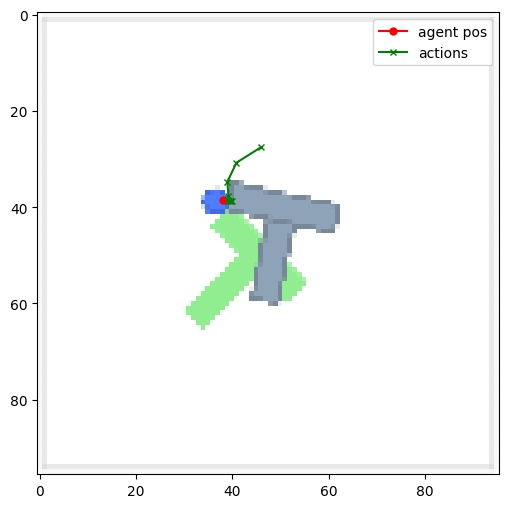

In [4]:
import matplotlib.pyplot as plt

# visualize data in batch
batch = next(iter(train_loader))
print("batch['image'].shape:", batch['image'].shape)
print("batch['agent_pos'].shape:", batch['agent_pos'].shape)
print("batch['action'].shape", batch['action'].shape)

nsample = {
    k: v[0] for k, v in batch.items()
}

# unnormalize data
agent_pos = unnormalize_data(nsample['agent_pos'].numpy(), stats['action']) * 96/512
action = unnormalize_data(nsample['action'].numpy(), stats['action']) * 96/512

img = nsample['image'][-1].numpy()
img = (np.moveaxis(img, 0, -1) * 255).astype(np.uint8)


plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.plot(agent_pos[:,0], agent_pos[:,1], 'r-o', markersize=5, label='agent pos')
plt.plot(action[:,0], action[:,1], 'g-x', markersize=5, label='actions')
plt.legend()
plt.show()

## Create Model

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
# model parameters
img_size = 96               # Training images are 96x96
in_channels = 3             # RGB images

n_enc_layers = 8
n_dec_layers = 8
n_queries = pred_horizon    # Number of actons

patch_size = 8
emb_dim = 512
n_heads = 16
n_layers = 12
dropout = 0.1

In [7]:
from action_model import VisionActionModel

model = VisionActionModel(img_size, patch_size, in_channels, emb_dim, n_heads, n_enc_layers, n_dec_layers, n_queries, dropout)
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')

VisionActionModel(
  (encoder): VisionEncoder(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(3, 512, kernel_size=(8, 8), stride=(8, 8))
    )
    (positional_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
    (encoder): ModuleList(
      (0-7): 8 x TransformerEncoder(
        (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mha): MultiHeadAttention(
          (W_o): Linear(in_features=512, out_features=512, bias=False)
          (heads): ModuleList(
            (0-15): 16 x AttentionHead(
              (query): Linear(in_features=512, out_features=32, bias=False)
              (key): Linear(in_features=512, out_features=32, bias=False)
              (value): Linear(in_features=512, out_features=32, bias=False)
            )
          )
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=5

## Training

In [8]:
import time
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import numpy as np

model = model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

num_epochs = 200
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs//10, eta_min=1e-7) # cosine annealing with restarts

# best model
best_val_loss = np.inf
MODEL_PATH = 'pusht_model_best.pth'

# training metrics to be plotted
train_losses = []
val_losses = []
learning_rates = []

start_time = time.time() # timing

for epoch in range(num_epochs):
    # Training
    model.train()
    epoch_train_loss = 0.0
    loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for batch in loop:
        images = batch['image'].squeeze(1).to(device) # squeeze images for obs_horizon=1
        actions = batch['action'].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, actions)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    
    train_losses.append(epoch_train_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].squeeze(1).to(device)
            actions = batch['action'].to(device)
            
            outputs = model(images)
            loss = criterion(outputs, actions)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"Epoch {epoch+1}: New best model saved with validation loss: {avg_val_loss:.4f}")

    # Step the scheduler and store LR
    scheduler.step()
    learning_rates.append(optimizer.param_groups[0]['lr'])


end_time = time.time()
training_duration = end_time - start_time
print(f"Total training time: {training_duration:.2f} seconds")
print(f"Best validation loss achieved: {best_val_loss:.4f}")

Epoch 1: New best model saved with validation loss: 1.2166


Epoch 2: New best model saved with validation loss: 1.2166


Epoch 3: New best model saved with validation loss: 1.2163


Epoch 4: New best model saved with validation loss: 0.5637


Epoch 5: New best model saved with validation loss: 0.5635


Epoch 6: New best model saved with validation loss: 0.3513


Epoch 7: New best model saved with validation loss: 0.1666


Epoch 8: New best model saved with validation loss: 0.1254


Epoch 9: New best model saved with validation loss: 0.0522


Epoch 10: New best model saved with validation loss: 0.0269


Epoch 11: New best model saved with validation loss: 0.0254


Epoch 12: New best model saved with validation loss: 0.0201


Epoch 13: New best model saved with validation loss: 0.0200


Epoch 14: New best model saved with validation loss: 0.0191


Epoch 15: New best model saved with validation loss: 0.0189


Epoch 16: New best model saved with validation loss: 0.0173


Epoch 17: New best model saved with validation loss: 0.0170


Epoch 18: New best model saved with validation loss: 0.0162


Epoch 19: New best model saved with validation loss: 0.0161


Epoch 20: New best model saved with validation loss: 0.0160


Epoch 22: New best model saved with validation loss: 0.0159


Epoch 24: New best model saved with validation loss: 0.0157


Epoch 27: New best model saved with validation loss: 0.0149


Epoch 28: New best model saved with validation loss: 0.0148


Epoch 29: New best model saved with validation loss: 0.0146


Epoch 32: New best model saved with validation loss: 0.0130


Epoch 33: New best model saved with validation loss: 0.0127


Epoch 39: New best model saved with validation loss: 0.0115


Epoch 41: New best model saved with validation loss: 0.0115


Epoch 42: New best model saved with validation loss: 0.0111


Epoch 44: New best model saved with validation loss: 0.0105


Epoch 46: New best model saved with validation loss: 0.0100


Epoch 47: New best model saved with validation loss: 0.0088


Epoch 48: New best model saved with validation loss: 0.0079


Epoch 49: New best model saved with validation loss: 0.0075


Epoch 51: New best model saved with validation loss: 0.0064


Epoch 52: New best model saved with validation loss: 0.0062


Epoch 53: New best model saved with validation loss: 0.0059


Epoch 54: New best model saved with validation loss: 0.0058


Epoch 55: New best model saved with validation loss: 0.0050


Epoch 57: New best model saved with validation loss: 0.0048


Epoch 58: New best model saved with validation loss: 0.0045


Epoch 59: New best model saved with validation loss: 0.0044


Epoch 60: New best model saved with validation loss: 0.0044


Epoch 62: New best model saved with validation loss: 0.0044


Epoch 65: New best model saved with validation loss: 0.0043


Epoch 91: New best model saved with validation loss: 0.0038


Epoch 92: New best model saved with validation loss: 0.0035


Epoch 93: New best model saved with validation loss: 0.0033


Epoch 94: New best model saved with validation loss: 0.0032


Epoch 95: New best model saved with validation loss: 0.0029


Epoch 96: New best model saved with validation loss: 0.0026


Epoch 97: New best model saved with validation loss: 0.0025


Epoch 99: New best model saved with validation loss: 0.0025


Epoch 100: New best model saved with validation loss: 0.0025


Epoch 102: New best model saved with validation loss: 0.0024


Epoch 104: New best model saved with validation loss: 0.0024


Epoch 130: New best model saved with validation loss: 0.0023


Epoch 132: New best model saved with validation loss: 0.0020


Epoch 133: New best model saved with validation loss: 0.0019


Epoch 135: New best model saved with validation loss: 0.0018


Epoch 136: New best model saved with validation loss: 0.0016


Epoch 137: New best model saved with validation loss: 0.0016


Epoch 138: New best model saved with validation loss: 0.0016


Epoch 139: New best model saved with validation loss: 0.0015


Epoch 144: New best model saved with validation loss: 0.0015


Epoch 173: New best model saved with validation loss: 0.0014


Epoch 174: New best model saved with validation loss: 0.0012


Epoch 175: New best model saved with validation loss: 0.0012


Epoch 176: New best model saved with validation loss: 0.0011


Epoch 177: New best model saved with validation loss: 0.0011


Epoch 178: New best model saved with validation loss: 0.0011


Epoch 179: New best model saved with validation loss: 0.0010


Epoch 182: New best model saved with validation loss: 0.0010


Total training time: 48973.46 seconds
Best validation loss achieved: 0.0010


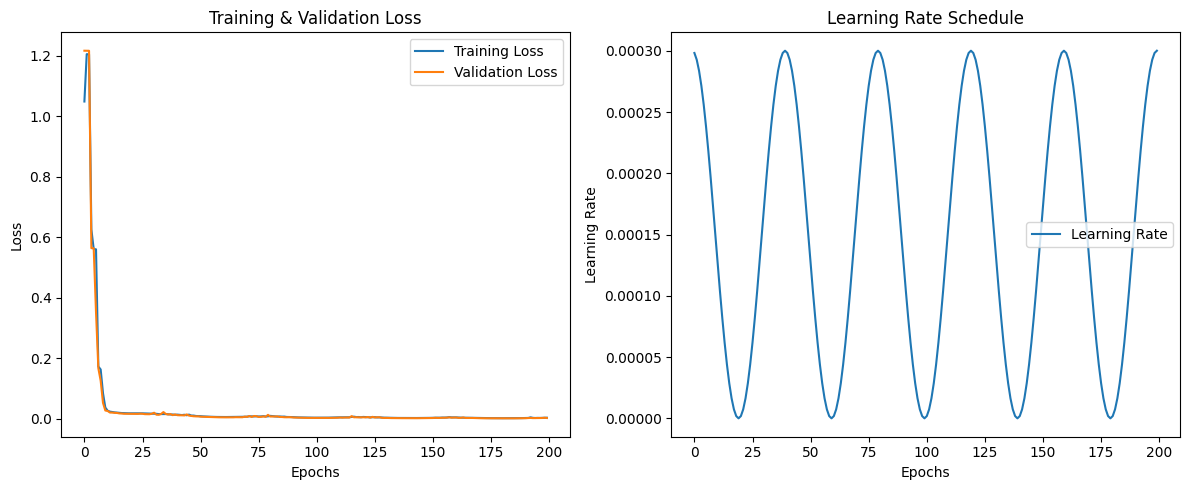

In [9]:
# Plotting the results
plt.figure(figsize=(12, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting learning rate
plt.subplot(1, 2, 2)
plt.plot(learning_rates, label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
MODEL_PATH = 'pusht_model.pth'

torch.save(model.state_dict(), MODEL_PATH)

print(f'Model saved to {MODEL_PATH}')

Model saved to pusht_model.pth


## Inference On Validation Set

In [12]:
# load best model
model.load_state_dict(torch.load('pusht_model_best.pth'))
model.to(device)

C:\Users\Florian Frick\AppData\Local\Temp\ipykernel_22004\255081635.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('pusht_model_best.pt

VisionActionModel(
  (encoder): VisionEncoder(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(3, 512, kernel_size=(8, 8), stride=(8, 8))
    )
    (positional_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
    (encoder): ModuleList(
      (0-7): 8 x TransformerEncoder(
        (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mha): MultiHeadAttention(
          (W_o): Linear(in_features=512, out_features=512, bias=False)
          (heads): ModuleList(
            (0-15): 16 x AttentionHead(
              (query): Linear(in_features=512, out_features=32, bias=False)
              (key): Linear(in_features=512, out_features=32, bias=False)
              (value): Linear(in_features=512, out_features=32, bias=False)
            )
          )
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=5

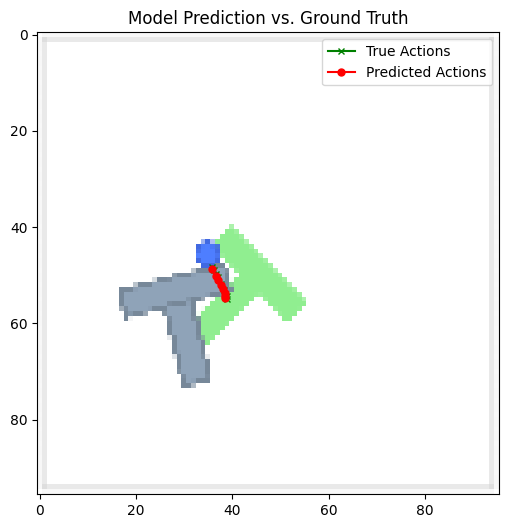

In [13]:

# After training, switch to evaluation mode
model.eval()

# Get a batch of data
batch = next(iter(val_loader))
images = batch['image'].squeeze(1).to(device)
true_actions = batch['action'].to(device)

with torch.no_grad():
    # Get model predictions
    predicted_actions = model(images)

# Move data to CPU for visualization
images_cpu = images.cpu().numpy()
true_actions_cpu = true_actions.cpu().numpy()
predicted_actions_cpu = predicted_actions.cpu().numpy()

# Select one example from the batch to visualize
idx_to_show = 1
img = images_cpu[idx_to_show]
# img = np.moveaxis(img, 0, -1).astype(np.uint8) # CHW to HWC
img = (np.moveaxis(img, 0, -1) * 255).astype(np.uint8) # CHW to HWC

true_action_points = unnormalize_data(true_actions_cpu[idx_to_show], stats['action']) * 96/512
predicted_action_points = unnormalize_data(predicted_actions_cpu[idx_to_show], stats['action']) *96/512 # {'min': 0, 'max': 96}


# Plotting
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.plot(true_action_points[:, 0], true_action_points[:, 1], 'g-x', markersize=5, label='True Actions')
plt.plot(predicted_action_points[:, 0], predicted_action_points[:, 1], 'r-o', markersize=5, label='Predicted Actions')
plt.legend()
plt.title("Model Prediction vs. Ground Truth")
plt.show()

## Test On Gym Environment

In [ ]:
from pusht_gym_env import PushTImageEnv
from tqdm import tqdm

# limit enviornment interaction to 200 steps before termination
max_steps = 1000
env = PushTImageEnv()
# use a seed >200 to avoid initial states seen in the training dataset
env.seed()

# get first observation
obs, info = env.reset()

# save visualization and rewards
imgs = [env.render(mode='rgb_array')]
rewards = list()
done = False
step_idx = 0

# ensure model is in evaluation mode
model.eval()
model.to(device)

with tqdm(total=max_steps, desc="Eval PushTImageEnv") as pbar:
    while not done:
        env_image = obs['image']

        # Add a batch dimension and move to cuda
        env_image = torch.from_numpy(env_image).unsqueeze(0).to(device, dtype=torch.float32)

        with torch.no_grad():
            predicted_nactions = model(env_image) # (B, C, H, W)

        predicted_nactions = predicted_nactions.detach().to('cpu').numpy() # Shape: (B, pred_horizon, 2) -> (1, 8, 2)
        
        action_pred = unnormalize_data(predicted_nactions[0], stats=stats['action'])
        
        # Execute the entire predicted action sequence
        for i in range(len(action_pred)):
            obs, reward, done, _, info = env.step(action_pred[i])
            
            # And reward/vis
            rewards.append(reward)
            imgs.append(env.render(mode='rgb_array'))

            # Update progress bar
            step_idx += 1
            pbar.update(1)
            pbar.set_postfix(reward=reward)
            if step_idx >= max_steps:
                done = True
            if done:
                break
        
        if done:
            break

# print out the maximum target coverage
print('Score: ', max(rewards))

# visualize
from skvideo.io import vwrite
from IPython.display import Video
fname = "vis5.mp4"
vwrite(fname, imgs)
Video(fname, embed=True, width=256, height=256)

Eval PushTImageEnv:  24%|██▍       | 238/1000 [00:03<00:09, 78.56it/s, reward=1]     


Score:  1.0


## Getting average score

In [16]:
from pusht_gym_env import PushTImageEnv
from tqdm import tqdm
num_episodes = 100
all_max_rewards = []
successful_episodes = 0
# limit enviornment interaction to 500 steps before termination
max_steps = 1000
env = PushTImageEnv()

# ensure model is in evaluation mode
model.eval()
model.to(device)

for episode_idx in tqdm(range(num_episodes), desc="Evaluating Episodes"):
    # use a seed >200 to avoid initial states seen in the training dataset
    env.seed(201 + episode_idx)

    # get first observation
    obs, info = env.reset()

    rewards = []
    done = False
    step_idx = 0

    while not done:
        env_image = obs['image']

        # Add a batch dimension and move to cuda
        env_image = torch.from_numpy(env_image).unsqueeze(0).to(device, dtype=torch.float32)

        with torch.no_grad():
            predicted_nactions = model(env_image)

        predicted_nactions = predicted_nactions.detach().to('cpu').numpy()
        
        action_pred = unnormalize_data(predicted_nactions[0], stats=stats['action'])
        
        # Execute the entire predicted action sequence
        for i in range(len(action_pred)):
            obs, reward, done, _, info = env.step(action_pred[i])
            
            rewards.append(reward)

            step_idx += 1
            if step_idx >= max_steps:
                done = True
            if done:
                break
        
        if done:
            break
    
    if rewards:
        r = max(rewards)
        all_max_rewards.append(r)
        if r > 0.95:
            successful_episodes += 1
    else:
        all_max_rewards.append(0)

# Calculate and print the average score
average_score = np.mean(all_max_rewards)
print(f'Max step per episode: {max_steps}')
print(f'\nAverage score over {num_episodes} episodes: {average_score:.4f}')
print(f'Successful episodes: {successful_episodes} out of {num_episodes}')

Evaluating Episodes: 100%|██████████| 100/100 [15:12<00:00,  9.12s/it]

Max step per episode: 1000

Average score over 100 episodes: 0.7817
Successful episodes: 55 out of 100
